In [ ]:
!pip install -r covid_clf/colab_requirements.txt
!pip install torch==1.5.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pandas

In [ ]:
!pip install scipy
!pip install matplotlib
!pip install scikit-learn
!pip install transformers

In [2]:
import os
import re
import csv
import math
import time
import random

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AutoModel, AutoTokenizer
from transformers import modeling_outputs

%matplotlib inline

In [3]:
SAVE = './covid_clf/checkpoints/'

In [4]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())
else:
  print("Using CPU, change runtime type to speed up fine-tuning")

GeForce GTX 1070 Ti


Data Import and EDA

In [5]:
data = pd.read_csv('./expanded_annotations.csv', header=0)
print(data.shape)
data.head()

(6492, 5)


,PREDICATE,SUBJECT_TEXT,OBJECT_TEXT,SENTENCE,LABEL
0,ADMINISTERED_TO,MTX,patients,"At 2 years of followup, 60 patients (48%) cont...",1
1,COEXISTS_WITH,foreign bodies,brain abscess,The diagnostic significance of change in posit...,1
2,USES,micropipet,glass,Unilateral microinjection of bombesin or vehic...,0
3,COEXISTS_WITH,monoclonal antibody,liposomes,A monoclonal antibody was produced that ...,1
4,TREATS,Infusion,rat,Infusion of prostacyclin (PGI2) reportedly att...,0


In [6]:
pd.crosstab(data.PREDICATE, data.LABEL)

LABEL,0,1
PREDICATE,,
ADMINISTERED_TO,18,175
AFFECTS,29,53
ASSOCIATED_WITH,12,70
AUGMENTS,29,53
CAUSES,15,67
COEXISTS_WITH,68,256
COMPLICATES,3,101
DIAGNOSES,39,152
DISRUPTS,31,51


(4280, 5)


<AxesSubplot:>

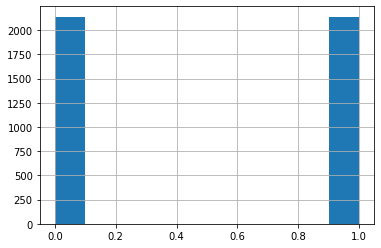

In [7]:
sub_data = data[data.LABEL == 0]
sub_data = pd.concat([sub_data, data[data.LABEL == 1].sample(n=len(sub_data), replace=False)])
print(sub_data.shape)
sub_data.LABEL.hist()

In [8]:
predicates = ['COEXISTS_WITH', 'COMPLICATES','MANIFESTATION_OF',
              'PREVENTS', 'PRODUCES', 'TREATS', 
              'INTERACTS_WITH', 'STIMULATES', 
              'INHIBITS', 'CAUSES', 'PREDISPOSES', 
              'ASSOCIATED_WITH', 'DISRUPTS', 'AUGMENTS', 
              'AFFECTS']

In [9]:
data = data[data.PREDICATE.isin(predicates)]
print(len(data))
print(data.LABEL.mean())
data.head()

4858
0.6058048579662413


,PREDICATE,SUBJECT_TEXT,OBJECT_TEXT,SENTENCE,LABEL
1,COEXISTS_WITH,foreign bodies,brain abscess,The diagnostic significance of change in posit...,1
3,COEXISTS_WITH,monoclonal antibody,liposomes,A monoclonal antibody was produced that ...,1
4,TREATS,Infusion,rat,Infusion of prostacyclin (PGI2) reportedly att...,0
5,TREATS,therapy,cancer,[Symptomatic butalidone therapy in cancer].,1
6,TREATS,chemotherapy,patients,Three patients relapsed after primary irradiat...,1


In [10]:
ctab = pd.crosstab(data.PREDICATE, data.LABEL)
print(len(ctab))
ctab

15


LABEL,0,1
PREDICATE,,
AFFECTS,29,53
ASSOCIATED_WITH,12,70
AUGMENTS,29,53
CAUSES,15,67
COEXISTS_WITH,68,256
COMPLICATES,3,101
DISRUPTS,31,51
INHIBITS,281,323
INTERACTS_WITH,756,1025


Mean:  0.6058048579662413


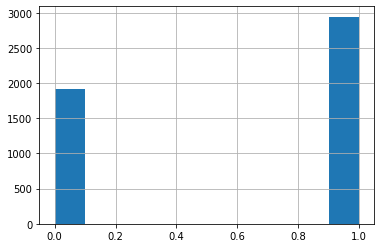

In [11]:
data.LABEL.hist()
print("Mean: ", data.LABEL.mean())

(3830, 5)


<AxesSubplot:>

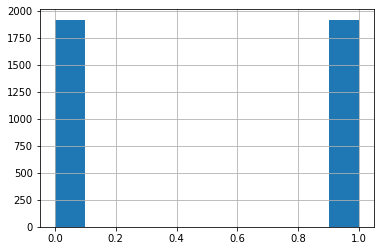

In [12]:
sub_data = data[data.LABEL == 0]
sub_data = pd.concat([sub_data, data[data.LABEL == 1].sample(n=len(sub_data), replace=False)])
print(sub_data.shape)
sub_data.LABEL.hist()

Data Preprocessing

In [13]:
def standardize_text(string):
  """
  Removes non-alphanumeric characters except hyphens
  Removes extra whitespaces
  """
  pattern = re.compile('[\W_]+')
  temp = pattern.sub(' ', string)
  temp = ' '.join(temp.split())
  temp = temp.lower()

  return temp

In [14]:
def make_tuple(string):
  toks = string.split('&')
  for i, tok in enumerate(toks):
    t = tok.split()
    t = ' '.join(t)
    toks[i] = t
  return tuple(toks)

sub_data['TRIPLE'] = (sub_data.SUBJECT_TEXT + '&' + sub_data.PREDICATE + '&' +sub_data.OBJECT_TEXT).apply(make_tuple)

sub_data['TRIPLE'].head(20)

4                                (Infusion, TREATS, rat)
7      (hydroxylase, COEXISTS_WITH, vitamin D3 metabo...
11                 (dehydroepiandrosterone, TREATS, men)
17     (apolipoproteins, COEXISTS_WITH, apolipoprotei...
22                                (DDS, TREATS, leprosy)
37                (Discharge planning, TREATS, children)
40                         (therapy, PREVENTS, toxicity)
42                (surgical procedures, TREATS, disease)
47                        (HeLa cells, PRODUCES, genome)
48     (skeletal pin fixation, PREVENTS, mandibular f...
51            (Gallium nitrate, PREVENTS, hypercalcemia)
54     (peripheral neurofibromatosis, COEXISTS_WITH, ...
56                          (abortion, TREATS, patients)
59                          (antiserum, TREATS, rabbits)
66                            (oestrogens, TREATS, boar)
69     (psychological, MANIFESTATION_OF, cognitive de...
80             (vaccination, TREATS, multiple sclerosis)
90                        (VACC

In [15]:
# Start with sentences and triples to be used for training
X = sub_data[['TRIPLE', 'SENTENCE']]
y = sub_data['LABEL'].values

In [16]:
def joining(text, triple):
  sub, pred, obj = triple
  text = ' '.join(text.split()) # Clears extra spaces
  text += f" [SEP] {sub} {pred} {obj}"
  return text

def triple_joining(triple):
  sub, pred, obj = triple
  return ' '.join([sub, pred, obj])

In [17]:
X = np.vectorize(joining)(X.SENTENCE, X.TRIPLE)

In [18]:
X[0]

'Infusion of prostacyclin (PGI2) reportedly attenuates renal ischemic injury in the dog and the rat. [SEP] Infusion TREATS rat'

**Modeling**

In [19]:
class PubMedBERT(nn.Module):
  """
  The PubMed implementation does not include a classification head
  so one must be added. The classification head is added in the same manner
  as the other HuggingFace BERT models for consistency.
  """
  def __init__(self):
    super().__init__()
    self.weight_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
    self.bert = AutoModel.from_pretrained(self.weight_path)
    self.drop = nn.Dropout(0.1, False)
    self.fc_out = nn.Linear(768, 2, True)

  def forward(self, input_ids, token_type_ids, attention_masks,
              return_dict=None):
    outputs = self.bert(input_ids, 
                             attention_mask=attention_masks,
                             token_type_ids=token_type_ids
                             )
    pooled_output = outputs[1]
    pooled_output = self.drop(pooled_output)
    logits = self.fc_out(pooled_output)

    loss = None
    if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

    return modeling_outputs.SequenceClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states, 
                                    attentions=outputs.attentions)


class BioClinicalBERT(nn.Module):
  """
  The Bio Clinical BERT implementation does not include a classification head
  so one must be added. The classification head is added in the same manner
  as the other HuggingFace BERT models for consistency.
  """
  def __init__(self):
    super().__init__()
    self.weight_path = "emilyalsentzer/Bio_ClinicalBERT"
    self.bert = AutoModel.from_pretrained(self.weight_path)
    self.drop = nn.Dropout(0.1, False)
    self.fc_out = nn.Linear(768, 2, True)

  def forward(self, input_ids, token_type_ids, attention_masks,
              return_dict=None):
    outputs = self.bert(input_ids, 
                             attention_mask=attention_masks,
                             token_type_ids=token_type_ids
                             )
    pooled_output = outputs[1]
    pooled_output = self.drop(pooled_output)
    logits = self.fc_out(pooled_output)

    loss = None
    if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

    return modeling_outputs.SequenceClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states, 
                                    attentions=outputs.attentions)


class BioBERT(nn.Module):
  """
  The Bio BERT implementation does not include a classification head
  so one must be added. The classification head is added in the same manner
  as the other HuggingFace BERT models for consistency.
  """
  def __init__(self):
    super().__init__()
    self.weight_path = "./biobert_v1.1_pubmed/"
    self.bert = AutoModel.from_pretrained(self.weight_path, force_download=True)
    self.drop = nn.Dropout(0.1, False)
    self.fc_out = nn.Linear(768, 2, True)
    
  def forward(self, input_ids, token_type_ids, attention_masks,
              return_dict=None):
    outputs = self.bert(input_ids, 
                             attention_mask=attention_masks,
                             token_type_ids=token_type_ids
                             )
    pooled_output = outputs[1]
    pooled_output = self.drop(pooled_output)
    logits = self.fc_out(pooled_output)

    loss = None
    if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

    return modeling_outputs.SequenceClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states, 
                                    attentions=outputs.attentions)


class BlueBERT(nn.Module):
  """
  The BlueBERT implementation does not include a classification head
  so one must be added. The classification head is added in the same manner
  as the other HuggingFace BERT models for consistency.
  """
  def __init__(self):
    super().__init__()
    self.weight_path = "./ncbi_bert_pubmed_mimic_uncased/"
    self.bert = AutoModel.from_pretrained(self.weight_path, force_download=True)
    self.drop = nn.Dropout(0.1, False)
    self.fc_out = nn.Linear(768, 2, True)

  def forward(self, input_ids, token_type_ids, attention_masks,
              return_dict=None):
    outputs = self.bert(input_ids, 
                             attention_mask=attention_masks,
                             token_type_ids=token_type_ids
                             )
    pooled_output = outputs[1]
    pooled_output = self.drop(pooled_output)
    logits = self.fc_out(pooled_output)

    loss = None
    if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

    return modeling_outputs.SequenceClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states, 
                                    attentions=outputs.attentions)


class SemMedDataset(Dataset):
  """
  Dataset class for the several input components
  """
  def __init__(self, input_ids, token_type_ids, attention_masks, labels):
    self.input_ids = input_ids
    self.token_types = token_type_ids
    self.attn_masks = attention_masks
    self.labels = labels

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    return self.input_ids[idx], self.token_types[idx], self.attn_masks[idx], self.labels[idx]

In [20]:
class Experiment:
  def __init__(self,
               num_trials,
               data,
               labels,
               model_type,
               frozen,
               epochs,
               bsz,
               lr,
               path,
               seeds
              ):
    """
    A single class to manage, execute, and hold the results of each experiment
    """
    assert len(seeds) == num_trials
    self.num_trials = num_trials
    self.data = data
    self.labels = labels
    self.model_type = model_type
    self.frozen = frozen
    self.epochs = epochs
    self.bsz = bsz
    self.lr = lr
    self.seeds = seeds
    self.path = path

    self.experiment_results = {}

    self.device = "cuda" if torch.cuda.is_available() else "cpu"

  def setup_trial(self, seed):
    """
    Seeds the RNGs, instantiates a new model, tokenizer, optimizer, and lr
    scheduler, and splits the data into training and test sets for each trial
    prior to running the trial
    """
    print(f"\tSeed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    print("\tLoading model...")
    if self.model_type in ['bert-base-uncased', 'bert-base-cased']:
      self.model = transformers.BertForSequenceClassification.from_pretrained(self.model_type)
    elif self.model_type == 'biobert':
      self.model = BioBERT()
    elif self.model_type == 'bluebert':
      self.model = BlueBERT()
    elif self.model_type == 'pubmedbert':
      self.model = PubMedBERT()
    elif self.model_type == 'bioclinicalbert':
      self.model = BioClinicalBERT()
    else:
      raise ValueError('Invalid model_type')
    
    print("\tLoading tokenizer...")
    if self.model_type in ['bert-base-uncased', 'bert-base-cased']:
      self.tokenizer = transformers.BertTokenizer.from_pretrained(self.model_type)
      self.model.resize_token_embeddings(len(self.tokenizer)) # Addition of tokens necessitates resizing
    else:
      self.tokenizer = AutoTokenizer.from_pretrained(self.model.weight_path) 
      self.model.bert.resize_token_embeddings(len(self.tokenizer))
    
    
    print("\tPrepping data...")
    self.train_loader, self.valid_loader, self.test_loader = self.prep_data()
    
    print("\tPreparing optimizer...")
    if self.frozen:
      no_decay = ['bias', 'LayerNorm.weight']
      optimizer_grouped_parameters = [
        {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
      ]
      self.optimizer = transformers.AdamW(optimizer_grouped_parameters, 
                                          lr=self.lr, weight_decay=0.01)
    else:
      self.optimizer = transformers.AdamW(self.model.parameters(),
                                          lr=self.lr, weight_decay=0.01)
    
    print("\tPreparing criterion...")
    self.criterion = nn.CrossEntropyLoss()
    
    print("\tPreparing LR scheduler...")
    self.scheduler = transformers.get_linear_schedule_with_warmup(optimizer=self.optimizer,
                                                             num_warmup_steps=150,
                                                             num_training_steps=self.epochs*len(self.train_loader)
    )
    
  def prep_data(self):
    """
    Handles preprocessing of the input data by tokenizing the sentences/predication
    pairs and splits the data into training and test PyTorch DataLoaders
    for fine-tuning
    """
    encoding = self.tokenizer(self.data.tolist(), 
                              return_tensors='pt', padding=True, truncation=True)
    input_ids_ = encoding['input_ids']
    token_type_ids_ = encoding['token_type_ids']
    attention_mask_ = encoding['attention_mask']

    train_tup, valid_tup, test_tup = self._data_split(input_ids_, 
                                           token_type_ids_,
                                           attention_mask_, 
                                           self.labels,
                                           0.1,
                                           0.1
                                          )
    
    train_dataset = SemMedDataset(*train_tup)
    valid_dataset = SemMedDataset(*valid_tup)
    test_dataset = SemMedDataset(*test_tup)

    train_loader = DataLoader(train_dataset, batch_size=self.bsz, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=1)
    test_loader = DataLoader(test_dataset, batch_size=1)

    return train_loader, valid_loader, test_loader

  def _data_split(self, input_ids, token_type_ids, 
                  attention_masks, labels, valid_prop, test_prop):
    """
    Randomly splits the data into train and test sets. Due to the nature of this
    data and how it needs to be fed to the HuggingFace models, using the standard
    train_test_split from scikit-learn was impractical.
    """
    assert 0 < valid_prop <1
    assert 0 < test_prop < 1
    n_all = len(labels)
    pos_cnt = labels.sum()
    neg_cnt = n_all - pos_cnt

    n_test = int(test_prop * n_all)
    n_test_pos = int(n_test * (pos_cnt / n_all))
    n_test_neg = n_test - n_test_pos

    pos_idx = [idx for idx, label in enumerate(labels) if label == 1]
    neg_idx = [idx for idx, label in enumerate(labels) if label == 0]

    test_pos_sample_idx = torch.tensor(np.random.choice(pos_idx, size=(n_test_pos),
                                                        replace=False),
                                       dtype=torch.long)
    test_neg_sample_idx = torch.tensor(np.random.choice(neg_idx, size=(n_test_neg),
                                                        replace=False),
                                       dtype=torch.long)
    test_sample_idx = torch.cat([test_pos_sample_idx,
                                 test_neg_sample_idx],
                                dim=0)
    
    rem_pos_idx = [idx for idx in pos_idx if idx not in test_pos_sample_idx]
    rem_neg_idx = [idx for idx in neg_idx if idx not in test_neg_sample_idx]

    rem = min(len(rem_pos_idx), len(rem_neg_idx))

    rem_pos_idx = np.random.choice(rem_pos_idx, size=(rem), replace=False)
    rem_neg_idx = np.random.choice(rem_neg_idx, size=(rem), replace=False)

    n_valid = int(rem * valid_prop)
    n_train = rem - n_valid 
    
    train_pos_sample_idx = torch.tensor(np.random.choice(rem_pos_idx, size=(n_train),
                                                         replace=False),
                                        dtype=torch.long)
    train_neg_sample_idx = torch.tensor(np.random.choice(rem_neg_idx, size=(n_train),
                                                         replace=False),
                                        dtype=torch.long)
    train_sample_idx = torch.cat([train_pos_sample_idx,
                                  train_neg_sample_idx],
                                 dim=0)
    
    valid_pos_sample_idx = torch.tensor([idx for idx in rem_pos_idx if idx not in train_pos_sample_idx])
    valid_neg_sample_idx = torch.tensor([idx for idx in rem_neg_idx if idx not in train_neg_sample_idx])
    valid_sample_idx = torch.cat([valid_pos_sample_idx,
                                  valid_neg_sample_idx],
                                 dim=0)

    labels = torch.tensor(labels)

    print("Valid intersect Train")
    print(set(valid_sample_idx.tolist()).intersection(set(train_sample_idx.tolist())))
    print("Valid intersect Test")
    print(set(valid_sample_idx.tolist()).intersection(set(test_sample_idx.tolist())))
    print("Train intersect Test")
    print(set(train_sample_idx.tolist()).intersection(set(test_sample_idx.tolist())))

    # Collect training samples
    # Stratified to be 50/50 split between 0/1 labels
    train_in_ids = input_ids.index_select(0, train_sample_idx)
    train_tt_ids = token_type_ids.index_select(0, train_sample_idx)
    train_am_ids = attention_masks.index_select(0, train_sample_idx)
    train_labels = labels.index_select(0, train_sample_idx)

    train_tuple = (train_in_ids, train_tt_ids, train_am_ids, train_labels)
    
    # Collect validation samples
    # Stratified to be 50/50 split between 0/1 labels
    valid_in_ids = input_ids.index_select(0, valid_sample_idx)
    valid_tt_ids = token_type_ids.index_select(0, valid_sample_idx)
    valid_am_ids = attention_masks.index_select(0, valid_sample_idx)
    valid_labels = labels.index_select(0, valid_sample_idx)

    valid_tuple = (valid_in_ids, valid_tt_ids, valid_am_ids, valid_labels)
    
    # Collect testing samples
    # Stratified to have the same label distribution as the original dataset
    test_in_ids = input_ids.index_select(0, test_sample_idx)
    test_tt_ids = token_type_ids.index_select(0, test_sample_idx)
    test_am_ids = attention_masks.index_select(0, test_sample_idx)
    test_labels = labels.index_select(0, test_sample_idx)

    test_tuple = (test_in_ids, test_tt_ids, test_am_ids, test_labels)

    return train_tuple, valid_tuple, test_tuple

  def run_trial(self, trial_num):
    """
    Executes a single trial from setup through fine_tuning and
    deposits the results into the experiment_results dictionary
    """
    # Fine-tune bert
    print(']==['*20)
    print(f'\tTRIAL {trial_num+1}'*8)
    print('=[]='*20)
    print(f"\tPreparing trial...")
    self.setup_trial(self.seeds[trial_num])
    print("\tRunning trial...")
    train_losses, valid_losses, test_preds, test_labels = self.finetune(trial_num)
    
    results = {'train_losses': train_losses,
               'valid_losses': valid_losses,
               'test_preds': test_preds,
               'test_f1': f1_score(test_labels, test_preds, 
                                   zero_division=0),
               'test_precision': precision_score(test_labels, test_preds, 
                                                 zero_division=0),
               'test_recall': recall_score(test_labels, test_preds, 
                                           zero_division=0)
               }
    
    self.experiment_results.update({f'trial_{trial_num+1}': results})
    print("\tFinished trial!!!")

  def finetune(self, trial_num):
    """
    Typical PyTorch training loop
    """
    all_train_losses = []
    all_valid_losses = []
    best_f1 = 0
    best_loss = np.inf
    early_stopping = 0

    self.model.to(self.device)

    for e in range(1, self.epochs+1):
      if early_stopping >= 3:
        print("Stopping!")
        break

      start_time = time.time()
      print("\t","-"*70)
      print("\t","="*15,f"\tEpoch: {e}\t", "="*15)

      ### TRAINING ###
      self.model.train()
      train_loss = 0
      batch_loss = 0
      for i, (input_id, ttid, attn_mask, label) in enumerate(self.train_loader):
        input_id, ttid = input_id.to(self.device), ttid.to(self.device)
        attn_mask, label = attn_mask.to(self.device), label.to(self.device)
        self.optimizer.zero_grad()
        output = self.model(input_id, ttid, attn_mask)
        loss = self.criterion(output[0], label)
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        preds = torch.argmax(F.softmax(output[0], dim=1), dim=1).cpu().detach().numpy()
        labels_ = label.cpu().detach().numpy()

        all_train_losses.append(loss.item())
        train_loss += loss.item()
        batch_loss += loss.item()

        if (i % 50 == 0) and (i > 0):
          print("\t\t\tBatch {:4d} Loss:\t{:.6f}".format(i,batch_loss/50))
          batch_loss = 0

      print("\t\tTraining Results:\n\t\tLoss: {:.6f}".format(train_loss / len(self.train_loader)))
      
      ### EVALUATE ###
      self.model.eval()
      valid_loss = 0
      
      valid_preds, valid_labels = [], []

      for input_id, ttid, attn_mask, label in self.valid_loader:
        input_id, ttid = input_id.to(self.device), ttid.to(self.device)
        attn_mask, label = attn_mask.to(self.device), label.to(self.device)
        output = self.model(input_id, ttid, attn_mask)
        loss = self.criterion(output[0], label)

        valid_preds.append(torch.argmax(F.softmax(output[0], dim=1), dim=1).cpu().detach().item())
        valid_labels.append(label.cpu().detach().item())
        all_valid_losses.append(loss.item())
        valid_loss += loss.item()
      
      valid_f1 = f1_score(valid_labels, valid_preds, zero_division=0)
      valid_recall = recall_score(valid_labels, valid_preds, zero_division=0)
      valid_precision = precision_score(valid_labels, valid_preds, zero_division=0)

      print("\t\tValidation Results:\n\t\tLoss: {:.6f}\tF1: {:.4f}".format(valid_loss / len(self.valid_loader),
                                                                      valid_f1))
      print("\t\t\tRecall: {:.4f}\tPrecision: {:.4f}".format(valid_recall, valid_precision))

      if valid_f1 > best_f1:
        print("New best f1! Saving weights...")
        torch.save(self.model.state_dict(), SAVE+self.path+str(trial_num)+'_'+self.model_type+'.pth')
        print("Saved!")
        print("Evaluating on test set...")
        best_f1 = valid_f1
        best_loss = valid_loss
        early_stopping = 0

        self.model.eval()
        test_loss = 0

        test_preds, test_labels = [], []

        for input_id, ttid, attn_mask, label in self.test_loader:
          input_id, ttid = input_id.to(self.device), ttid.to(self.device)
          attn_mask, label = attn_mask.to(self.device), label.to(self.device)
          output = self.model(input_id, ttid, attn_mask)
          loss = self.criterion(output[0], label)

          test_preds.append(torch.argmax(F.softmax(output[0], dim=1), dim=1).cpu().detach().item())
          test_labels.append(label.cpu().detach().item())
          test_loss += loss.item()

        test_f1 = f1_score(test_labels, test_preds, zero_division=0)
        test_recall = recall_score(test_labels, test_preds, zero_division=0)
        test_precision = precision_score(test_labels, test_preds, zero_division=0)
        print("\t\tTest Results:\n\t\tLoss: {:.6f}\tF1: {:.4f}".format(test_loss / len(self.test_loader),
                                                                      test_f1))
        print("\t\t\tRecall: {:.4f}\tPrecision: {:.4f}".format(test_recall, test_precision))
        best_test_f1 = test_f1

      else:
        early_stopping += 1

    
    ### TEST ###
    self.model.eval()
    test_loss = 0

    test_preds, test_labels = [], []

    for input_id, ttid, attn_mask, label in self.test_loader:
      input_id, ttid = input_id.to(self.device), ttid.to(self.device)
      attn_mask, label = attn_mask.to(self.device), label.to(self.device)
      output = self.model(input_id, ttid, attn_mask)
      loss = self.criterion(output[0], label)

      test_preds.append(torch.argmax(F.softmax(output[0], dim=1), dim=1).cpu().detach().item())
      test_labels.append(label.cpu().detach().item())
      test_loss += loss.item()

    test_f1 = f1_score(test_labels, test_preds, zero_division=0)
    test_recall = recall_score(test_labels, test_preds, zero_division=0)
    test_precision = precision_score(test_labels, test_preds, zero_division=0)
    print("\t\tTest Results:\n\t\tLoss: {:.6f}\tF1: {:.4f}".format(test_loss / len(self.test_loader),
                                                                  test_f1))
    print("\t\t\tRecall: {:.4f}\tPrecision: {:.4f}".format(test_recall, test_precision))

    print("\t\tBest Validation F1: {:.4f}".format(best_f1))
    print("\t\tTest F1 at Best Val: {:.4f}".format(best_test_f1))

    print("\t\tTime elapsed: {:.6f}".format(time.time()-start_time))

    print("\t","-"*70)

    return all_train_losses, all_valid_losses, test_preds, test_labels

  def run_experiments(self):
    """
    Runs all of the trials for the experiment
    """
    for i in range(0, self.num_trials):
      self.run_trial(i)
      self.plot_running_avg(i)
      # self.write_results(i)
      # self.wrong_examples()
      print("\n\n") 

    print("Experiment completed!!")

  def plot_running_avg(self, trial_num, window=25):
    """
    Plots the rolling average for a specified window over
    the train losses from a trial
    """
    trial_num += 1
    losses = np.array(self.experiment_results[f'trial_{trial_num}']['train_losses'])
    N = len(losses)
    running_avg = np.empty(N)
    
    for t in range(N):
        running_avg[t] = losses[max(0, t-window):t+1].mean()
    
    plt.plot(running_avg)
    plt.title(f"Running Average ({window}) Loss")
    plt.show()

  def write_results(self, trial_num):
    """
    Writes trial parameters, train losses, and test losses to text and csv files,
    respectively, for future reference
    """
    trial_num += 1
    results_dir = f'{self.model_type}_{self.frozen}'

    if results_dir not in os.listdir():
      os.makedirs(results_dir)

    results_dir += f'/trial_{trial_num}/'

    os.makedirs(results_dir)

    with open(results_dir+"params.txt", 'w') as f:
      f.write(f"Time: {time.time()}\n")
      f.write(f"Bert Type: {self.model_type}\n")
      f.write(f"Frozen Body: {self.frozen}\n")
      f.write(f"Batch Size: {self.bsz}\n")
      f.write(f"Epochs: {self.epochs}\n")
      f.write(f"Learning Rate: {self.lr}\n")
      f.write(f"Seed: {self.seeds[trial_num-1]}\n")
    f.close()

    with open(results_dir+"train_loss.csv", 'w', newline='') as f:
      wr = csv.writer(f, quoting=csv.QUOTE_ALL)
      wr.writerow(self.experiment_results[f'trial_{trial_num}']['train_losses'])
    f.close()

    with open(results_dir+"valid_loss.csv", 'w', newline='') as f:
      wr = csv.writer(f, quoting=csv.QUOTE_ALL)
      wr.writerow(self.experiment_results[f'trial_{trial_num}']['test_losses'])
    f.close()

    print("Data saved!")

In [21]:
NUM_TRIALS = 10
SEEDS = np.random.randint(0, 10000, size=(NUM_TRIALS))
print(SEEDS)

[9653 8081 6179 3830 3362  145 9279 6775 7095 6018]


In [22]:
# Fixed hyperparameters
EPOCHS = 7
LR = 1e-5
BSZ = 16 # small due to memory restrictions

In [ ]:
bert_uncased = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='bert-base-uncased',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='bert_uncased',
                      seeds=SEEDS
                      )

In [ ]:
bert_uncased.run_experiments()

In [ ]:
bert_cased = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='bert-base-cased',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='bert_cased',
                      seeds=SEEDS
                      )

In [ ]:
bert_cased.run_experiments()

In [ ]:
biobert = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='biobert',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='biobert',
                      seeds=SEEDS
)

In [ ]:
biobert.run_experiments()

In [ ]:
bioclinbert = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='bioclinicalbert',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='bioclinicalbert',
                      seeds=SEEDS
                      )

In [ ]:
bioclinbert.run_experiments()

In [ ]:
bluebert = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='bluebert',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='bluebert',
                      seeds=SEEDS
                      )

In [ ]:
bluebert.run_experiments()

In [22]:
pubmedbert = Experiment(num_trials=NUM_TRIALS,
                      data=X,
                      labels=y,
                      model_type='pubmedbert',
                      frozen=False,
                      epochs=EPOCHS,
                      bsz=BSZ,
                      lr=LR,
                      path='pubmedbert',
                      seeds=SEEDS
                      )

]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1	TRIAL 1
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 9585
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...


/home/jav/miniconda3/envs/predfilter/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============
			Batch   50 Loss:	0.726292
			Batch  100 Loss:	0.676544
			Batch  150 Loss:	0.652240
		Training Results:
		Loss: 0.671413
		Validation Results:
		Loss: 0.618196	F1: 0.6576
			Recall: 0.7035	Precision: 0.6173
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.593482	F1: 0.6970
			Recall: 0.8010	Precision: 0.6169
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.597044
			Batch  100 Loss:	0.568435
			Batch  150 Loss:	0.517202
		Training Results:
		Loss: 0.547503
		Validation Results:
		Loss: 0.484899	F1: 0.7957
			Recall: 0.8605	Precision: 0.7400
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.522749	F1: 0.7717
			Recall: 0.8848	Precision: 0.6842
	 ------------------------------------------------------

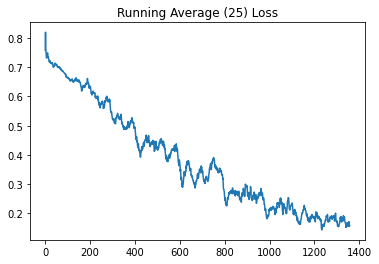




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2	TRIAL 2
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 4667
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============


/home/jav/miniconda3/envs/predfilter/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


			Batch   50 Loss:	0.719455
			Batch  100 Loss:	0.681516
			Batch  150 Loss:	0.662079
		Training Results:
		Loss: 0.667908
		Validation Results:
		Loss: 0.575063	F1: 0.6789
			Recall: 0.6453	Precision: 0.7161
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.583926	F1: 0.6686
			Recall: 0.6126	Precision: 0.7358
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.572922
			Batch  100 Loss:	0.549274
			Batch  150 Loss:	0.507368
		Training Results:
		Loss: 0.527669
		Validation Results:
		Loss: 0.466157	F1: 0.7990
			Recall: 0.8895	Precision: 0.7251
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.513731	F1: 0.7822
			Recall: 0.8743	Precision: 0.7076
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 3	 ===============
			Batch   50 Loss:	0.413356
			Batch  100 Loss:	0.41429

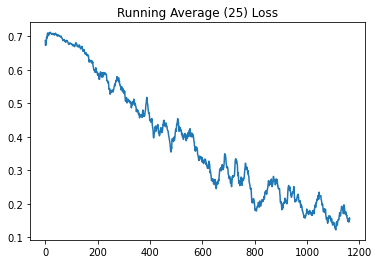




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3	TRIAL 3
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 2166
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============


/home/jav/miniconda3/envs/predfilter/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


			Batch   50 Loss:	0.721406
			Batch  100 Loss:	0.663871
			Batch  150 Loss:	0.648374
		Training Results:
		Loss: 0.655363
		Validation Results:
		Loss: 0.595634	F1: 0.7263
			Recall: 0.8023	Precision: 0.6635
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.633812	F1: 0.7073
			Recall: 0.7906	Precision: 0.6398
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.576870
			Batch  100 Loss:	0.565600
			Batch  150 Loss:	0.547152
		Training Results:
		Loss: 0.546580
		Validation Results:
		Loss: 0.487994	F1: 0.7564
			Recall: 0.7674	Precision: 0.7458
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.550301	F1: 0.7273
			Recall: 0.7330	Precision: 0.7216
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 3	 ===============
			Batch   50 Loss:	0.439011
			Batch  100 Loss:	0.40987

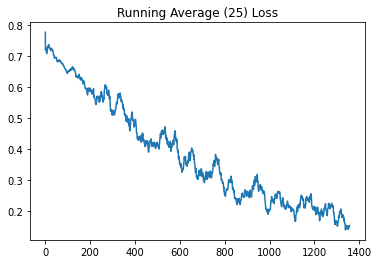




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4	TRIAL 4
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 566
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============


/home/jav/miniconda3/envs/predfilter/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


			Batch   50 Loss:	0.711543
			Batch  100 Loss:	0.672523
			Batch  150 Loss:	0.646642
		Training Results:
		Loss: 0.660431
		Validation Results:
		Loss: 0.601745	F1: 0.6959
			Recall: 0.7384	Precision: 0.6580
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.579815	F1: 0.7214
			Recall: 0.7592	Precision: 0.6872
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.595139
			Batch  100 Loss:	0.550067
			Batch  150 Loss:	0.502680
		Training Results:
		Loss: 0.545219
		Validation Results:
		Loss: 0.537944	F1: 0.7604
			Recall: 0.8488	Precision: 0.6887
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.501578	F1: 0.7644
			Recall: 0.8325	Precision: 0.7067
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 3	 ===============
			Batch   50 Loss:	0.425633
			Batch  100 Loss:	0.45173

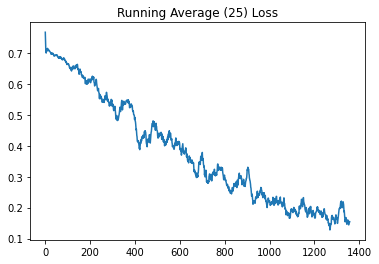




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5	TRIAL 5
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 2403
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============


/home/jav/miniconda3/envs/predfilter/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


			Batch   50 Loss:	0.743646
			Batch  100 Loss:	0.677107
			Batch  150 Loss:	0.633642
		Training Results:
		Loss: 0.665829
		Validation Results:
		Loss: 0.641130	F1: 0.7119
			Recall: 0.8837	Precision: 0.5961
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.634904	F1: 0.7172
			Recall: 0.9162	Precision: 0.5892
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.564675
			Batch  100 Loss:	0.546367
			Batch  150 Loss:	0.550278
		Training Results:
		Loss: 0.544416
		Validation Results:
		Loss: 0.537451	F1: 0.7778
			Recall: 0.8547	Precision: 0.7136
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.508097	F1: 0.8010
			Recall: 0.8639	Precision: 0.7466
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 3	 ===============
			Batch   50 Loss:	0.431827
			Batch  100 Loss:	0.43555

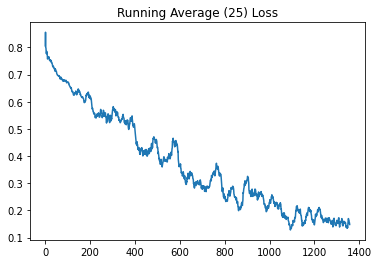




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6	TRIAL 6
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 9353
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============


/home/jav/miniconda3/envs/predfilter/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


			Batch   50 Loss:	0.688366
			Batch  100 Loss:	0.656730
			Batch  150 Loss:	0.620708
		Training Results:
		Loss: 0.644873
		Validation Results:
		Loss: 0.562899	F1: 0.7112
			Recall: 0.6802	Precision: 0.7452
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.570616	F1: 0.7043
			Recall: 0.6859	Precision: 0.7238
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.551137
			Batch  100 Loss:	0.511618
			Batch  150 Loss:	0.510652
		Training Results:
		Loss: 0.509483
		Validation Results:
		Loss: 0.436512	F1: 0.7944
			Recall: 0.8198	Precision: 0.7705
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.462325	F1: 0.7876
			Recall: 0.7958	Precision: 0.7795
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 3	 ===============
			Batch   50 Loss:	0.388615
			Batch  100 Loss:	0.40521

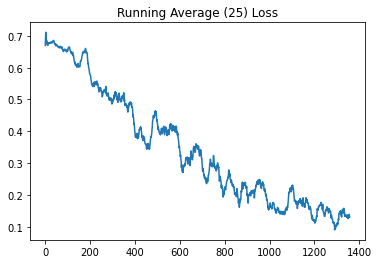




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7	TRIAL 7
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 4589
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============


/home/jav/miniconda3/envs/predfilter/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


			Batch   50 Loss:	0.702345
			Batch  100 Loss:	0.661019
			Batch  150 Loss:	0.639025
		Training Results:
		Loss: 0.653150
		Validation Results:
		Loss: 0.597958	F1: 0.7374
			Recall: 0.8488	Precision: 0.6518
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.597027	F1: 0.7240
			Recall: 0.8377	Precision: 0.6375
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.595899
			Batch  100 Loss:	0.537369
			Batch  150 Loss:	0.534808
		Training Results:
		Loss: 0.535741
		Validation Results:
		Loss: 0.565956	F1: 0.7758
			Recall: 0.8953	Precision: 0.6844
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.506061	F1: 0.8071
			Recall: 0.9529	Precision: 0.7000
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 3	 ===============
			Batch   50 Loss:	0.407835
			Batch  100 Loss:	0.45501

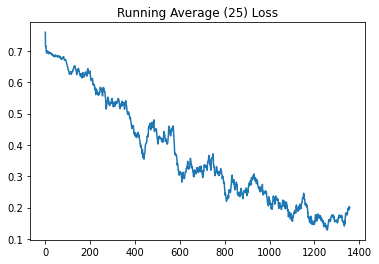




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8	TRIAL 8
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 1389
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============


/home/jav/miniconda3/envs/predfilter/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


			Batch   50 Loss:	0.706045
			Batch  100 Loss:	0.659548
			Batch  150 Loss:	0.633140
		Training Results:
		Loss: 0.645035
		Validation Results:
		Loss: 0.653417	F1: 0.7080
			Recall: 0.8953	Precision: 0.5856
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.644969	F1: 0.6996
			Recall: 0.8534	Precision: 0.5927
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.570793
			Batch  100 Loss:	0.552518
			Batch  150 Loss:	0.465733
		Training Results:
		Loss: 0.518859
		Validation Results:
		Loss: 0.541291	F1: 0.7727
			Recall: 0.8895	Precision: 0.6830
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.540551	F1: 0.7696
			Recall: 0.8743	Precision: 0.6872
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 3	 ===============
			Batch   50 Loss:	0.379598
			Batch  100 Loss:	0.44200

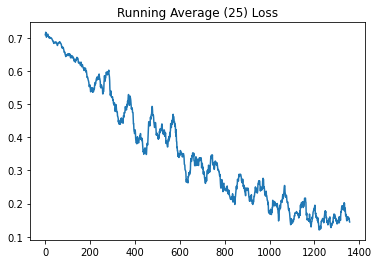




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9	TRIAL 9
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 2781
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============


/home/jav/miniconda3/envs/predfilter/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


			Batch   50 Loss:	0.698588
			Batch  100 Loss:	0.674554
			Batch  150 Loss:	0.643500
		Training Results:
		Loss: 0.657253
		Validation Results:
		Loss: 0.614315	F1: 0.6719
			Recall: 0.7500	Precision: 0.6085
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.597496	F1: 0.7277
			Recall: 0.8534	Precision: 0.6342
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.561043
			Batch  100 Loss:	0.554634
			Batch  150 Loss:	0.534615
		Training Results:
		Loss: 0.539366
		Validation Results:
		Loss: 0.583173	F1: 0.7500
			Recall: 0.8895	Precision: 0.6483
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.568829	F1: 0.7665
			Recall: 0.9110	Precision: 0.6616
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 3	 ===============
			Batch   50 Loss:	0.428978
			Batch  100 Loss:	0.42757

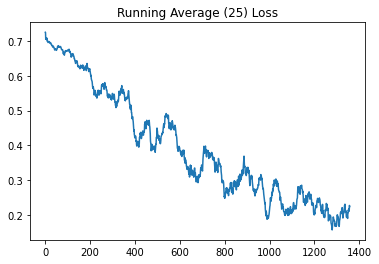




]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[
	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10	TRIAL 10
=[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]==[]=
	Preparing trial...
	Seed: 8804
	Loading model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Loading tokenizer...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


	Prepping data...
Valid intersect Train
set()
Valid intersect Test
set()
Train intersect Test
set()
	Preparing optimizer...
	Preparing criterion...
	Preparing LR scheduler...
	Running trial...
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 1	 ===============


/home/jav/miniconda3/envs/predfilter/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


			Batch   50 Loss:	0.722414
			Batch  100 Loss:	0.660500
			Batch  150 Loss:	0.635041
		Training Results:
		Loss: 0.659538
		Validation Results:
		Loss: 0.542388	F1: 0.7300
			Recall: 0.7151	Precision: 0.7455
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.578360	F1: 0.6959
			Recall: 0.6649	Precision: 0.7299
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 2	 ===============
			Batch   50 Loss:	0.573822
			Batch  100 Loss:	0.576600
			Batch  150 Loss:	0.537729
		Training Results:
		Loss: 0.550356
		Validation Results:
		Loss: 0.532452	F1: 0.7729
			Recall: 0.9302	Precision: 0.6612
New best f1! Saving weights...
Saved!
Evaluating on test set...
		Test Results:
		Loss: 0.566101	F1: 0.7638
			Recall: 0.9058	Precision: 0.6603
	 ----------------------------------------------------------------------
	 =============== 	Epoch: 3	 ===============
			Batch   50 Loss:	0.443927
			Batch  100 Loss:	0.46412

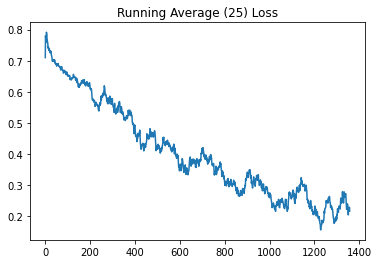




Experiment completed!!


In [23]:
pubmedbert.run_experiments()

In [23]:
#SAVE = 'covif_clf/checkpoints'
bert = PubMedBERT()  # Best performing model
bert.load_state_dict(torch.load(SAVE+'pubmedbert6_pubmedbert.pth'))
bert.eval()

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PubMedBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
 

In [24]:
tokenizer = AutoTokenizer.from_pretrained(bert.weight_path)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

bert.to(device)

data = pd.read_csv(SAVE + 'reduced_preds.csv', sep='\t', header=0)

encoding = tokenizer(data, return_tensors='pt', 
                     padding=True, truncation=True, 
                     verbose=False)

input_ids = encoding['input_ids'].to(device)
token_type_ids = encoding['token_type_ids'].to(device)
attn_mask = encoding['attention_mask'].to(device)

In [ ]:
keep = []

for i, row in data.iterrows():
  output = bert(input_ids, token_type_ids, attn_mask)
  clf = torch.argmax(F.softmax(output[1], dim=1), dim=1).cpu().detach().item()
  if clf >= 0.5:
    keep.append(row)

In [ ]:
keep = pd.DataFrame(keep)
keep.to_csv(SAVE+'filtered_preds.csv', sep='|', header=True, index=False)